In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
random.seed(30)

# **> Autocorrelation Function** (ACF)

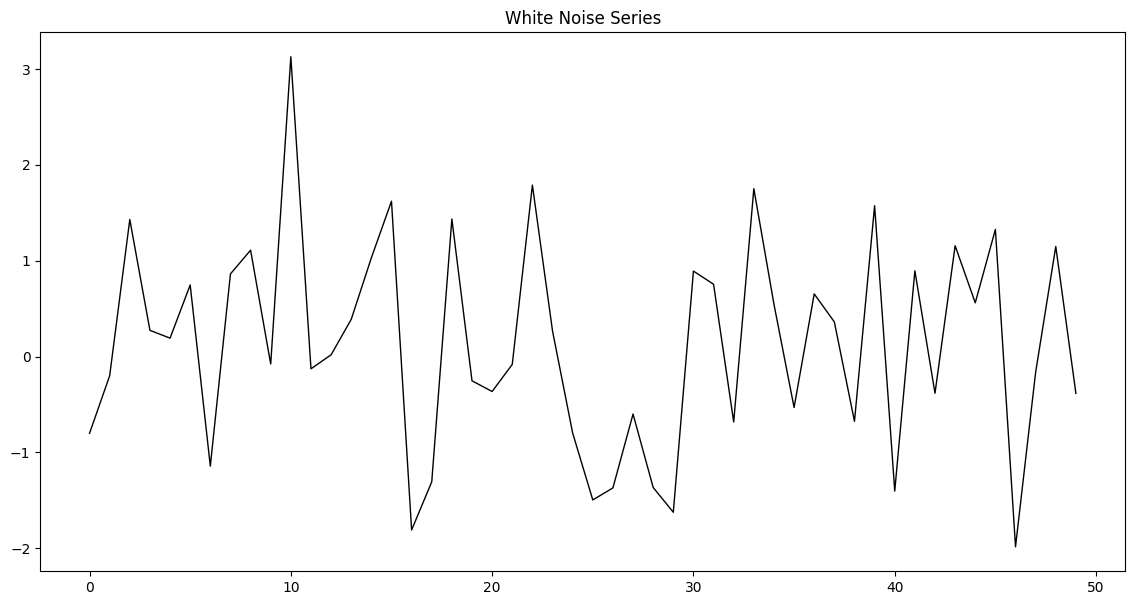

In [3]:
# get the white noise distribution
white_noise = [random.gauss(0, 1) for i in range(50)]

# plot the white noise

figure = plt.figure(figsize=(14, 7))

plt.plot(white_noise,
         color='black',
         linestyle='-',
         linewidth=1)

plt.title('White Noise Series')
plt.show()

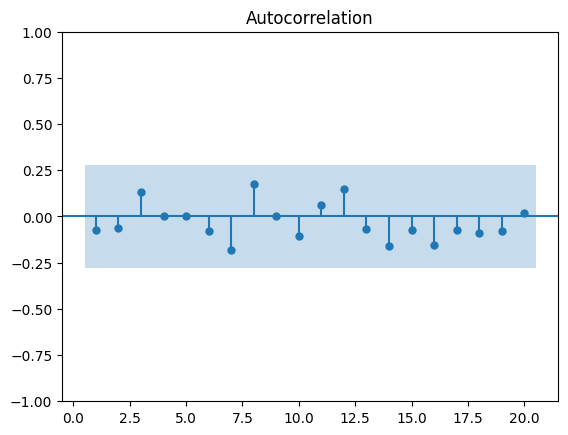

In [4]:
plot_acf(white_noise, lags=range(1, 21), fft=False, alpha=0.05, bartlett_confint=False)
plt.show()

# **> Simple forecasting methods to use as baseline**

In [5]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. Previous values are of the form '2019 Q1'.
    The function splits the string into year and quarter and returns a pandas period object.
    """
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

In [6]:
aus_production = pd.read_csv('data/aus_production.csv')

In [7]:
aus_production['Quarter'] = aus_production['Quarter'].apply(convert_to_period)

In [8]:
# get quarters after 1970Q1 and before 2004Q4
flt = (aus_production["Quarter"] >= "1970Q1") & (aus_production["Quarter"] <= "2004Q4")
bricks = aus_production[["Quarter", "Bricks"]][flt]
bricks.set_index("Quarter", inplace=True)

In [9]:
bricks.head()

,Bricks
Quarter,
1970Q1,386.0
1970Q2,428.0
1970Q3,434.0
1970Q4,417.0
1971Q1,385.0


In [10]:
def fit_and_plot(dataset, strategy, sp=1):
    """
    Function to fit a forecasting strategy and plot the results.
    """
    forecaster = NaiveForecaster(strategy=strategy, sp=sp)
    forecaster.fit(dataset)
    y_pred = forecaster.predict(list(range(1, 8)))
    pred_intervals_95 = forecaster.predict_interval(coverage=0.95)
    pred_intervals_80 = forecaster.predict_interval(coverage=0.80)
    
    plot_series(dataset, 
                y_pred, 
                labels=["y_train", "y_pred"], 
                pred_interval=pred_intervals_95)
    
    plot_series(dataset,
                y_pred,
                labels=["y_train", "y_pred"],
                pred_interval=pred_intervals_80)
    
    plt.show()

## **Mean method**

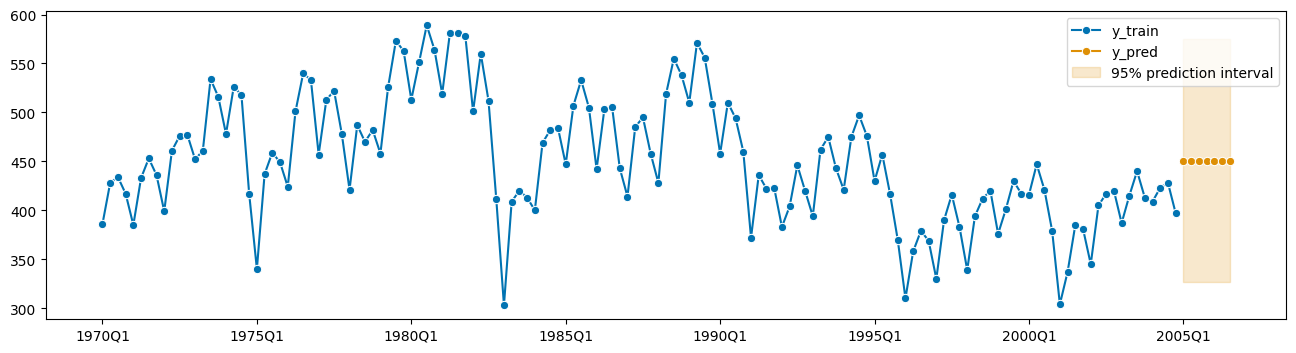

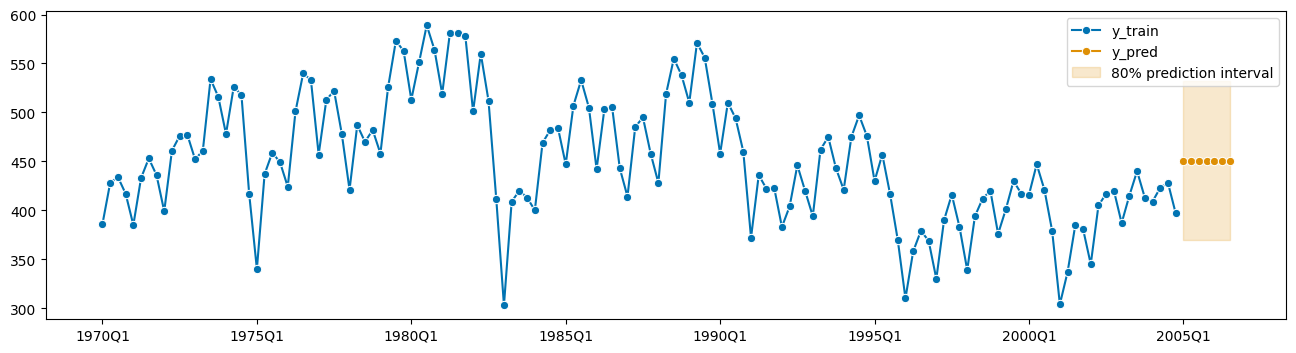

In [11]:
fit_and_plot(bricks, strategy="mean")

## **Naive (or random walk) method**

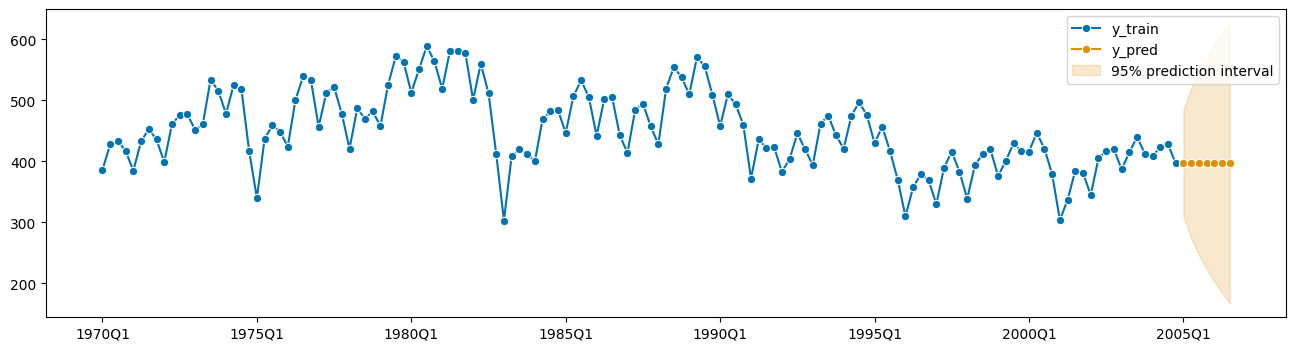

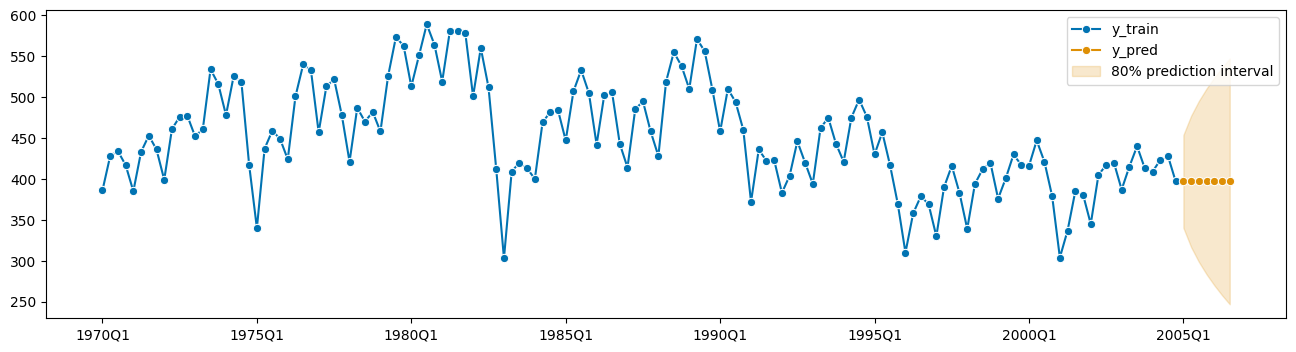

In [12]:
fit_and_plot(bricks, strategy="last")

## **Seasonal Naive method**

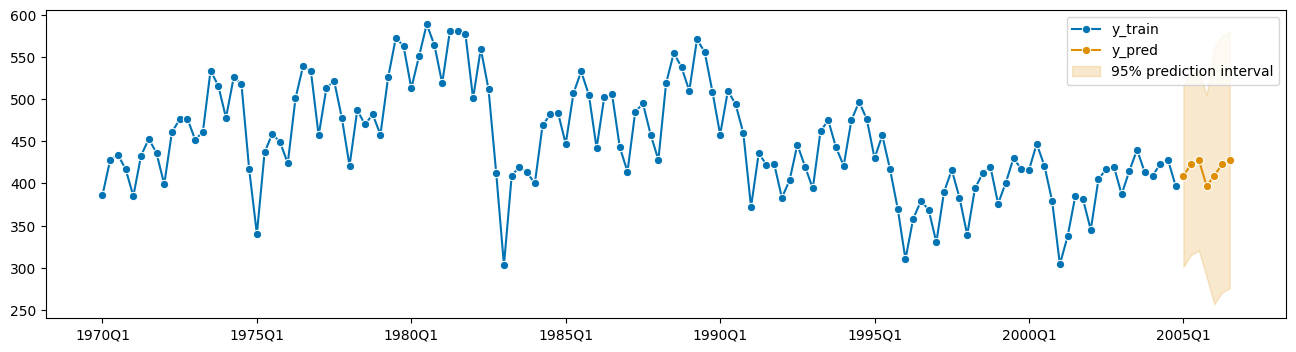

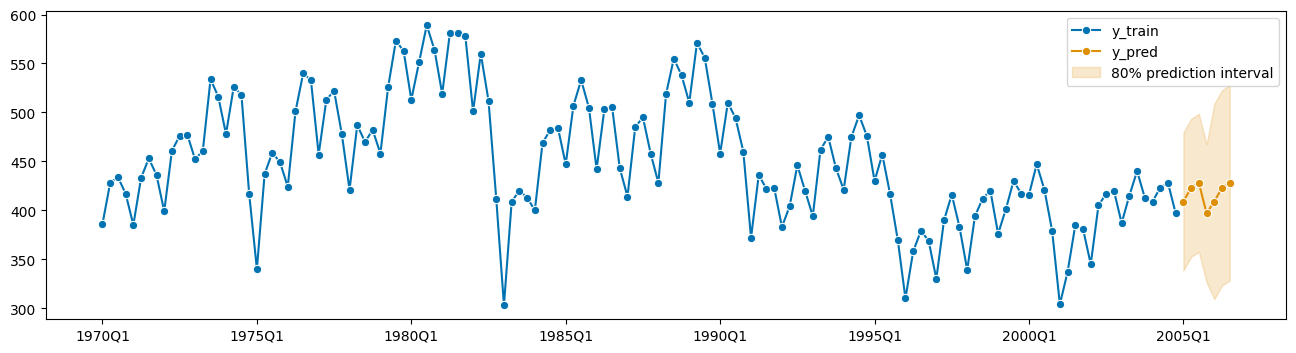

In [13]:
fit_and_plot(bricks, strategy="last", sp=4)

## **Drift method**

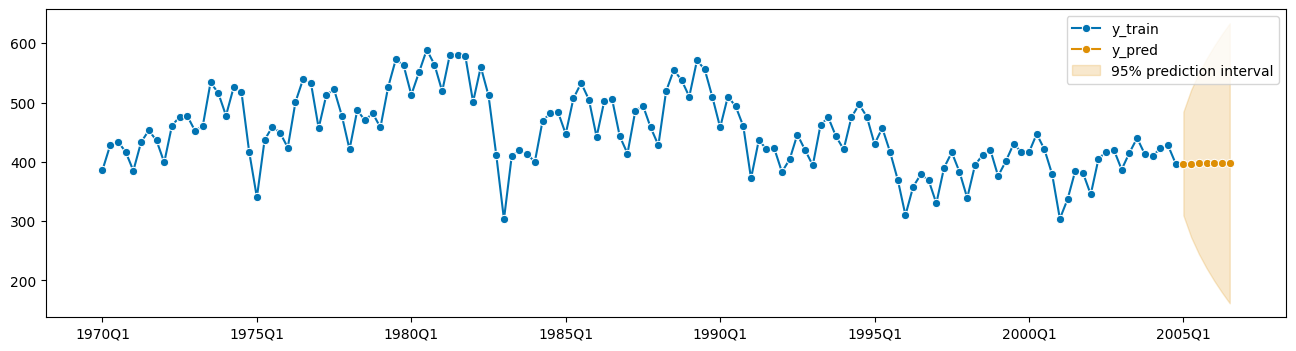

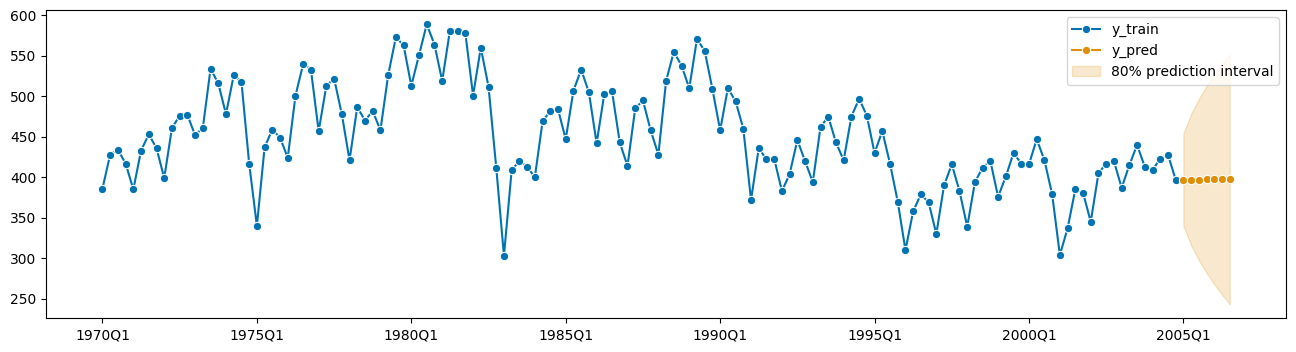

In [14]:
fit_and_plot(bricks, strategy="drift")

Trying on a different time period...

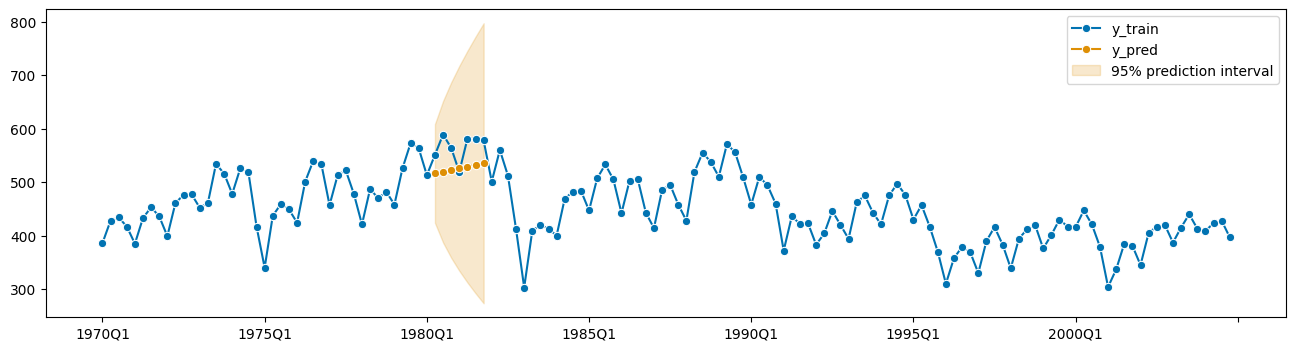

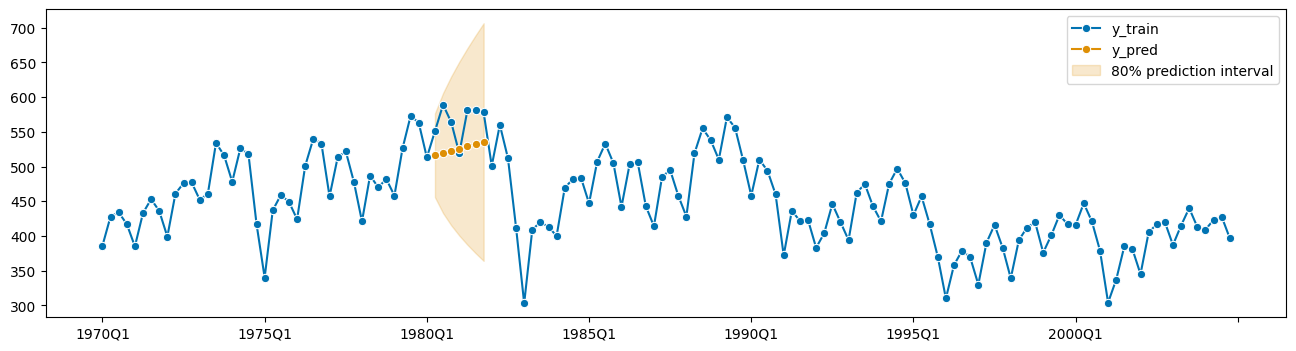

In [15]:
bricks_1970_1980 = bricks.filter(pd.period_range('1970Q1', '1980Q1', freq='Q'), axis=0)

forecaster = NaiveForecaster(strategy="drift")

# fit model
forecaster.fit(bricks_1970_1980)

# predict 8 quarters
y_pred = forecaster.predict(fh=range(1,8))

# get 95% prediction intervals
pred_intervals_95 = forecaster.predict_interval(coverage=0.95)

# get 80% prediction intervals
pred_intervals_80 = forecaster.predict_interval(coverage=0.80)

plot_series(bricks, y_pred, labels=["y_train", "y_pred"], pred_interval=pred_intervals_95)
plot_series(bricks, y_pred, labels=["y_train", "y_pred"], pred_interval=pred_intervals_80)
plt.show()

## **Example:** Australian quarterly beer production

In [16]:
flt = (aus_production["Quarter"] >= "1992Q1") & (aus_production["Quarter"] <= "2006Q4")
beer = aus_production[["Quarter", "Beer"]][flt]

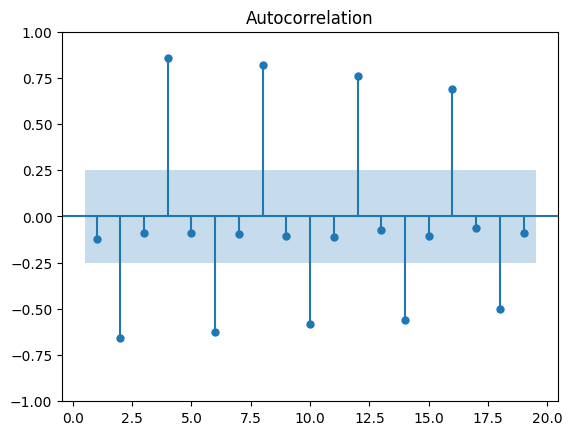

In [17]:
plot_acf(beer["Beer"], lags=range(1, 20), fft=True, alpha=0.05, bartlett_confint=False)
plt.show()

In [18]:
# fitting mean, naive and seasonal naive models

Mean = NaiveForecaster(strategy="mean")
Mean.fit(beer["Beer"])
y_pred_Mean = Mean.predict(list(range(1, 14)))
y_pred_Mean.index = pd.period_range(start="2007Q1", periods=13, freq="Q")

Naive = NaiveForecaster(strategy="last")
Naive.fit(beer["Beer"])
y_pred_Naive = Naive.predict(list(range(1, 14)))
y_pred_Naive.index = pd.period_range(start="2007Q1", periods=13, freq="Q")

SNaive = NaiveForecaster(strategy="last", sp=4)
SNaive.fit(beer["Beer"])
y_pred_SNaive = SNaive.predict(list(range(1, 14)))
y_pred_SNaive.index = pd.period_range(start="2007Q1", periods=13, freq="Q")

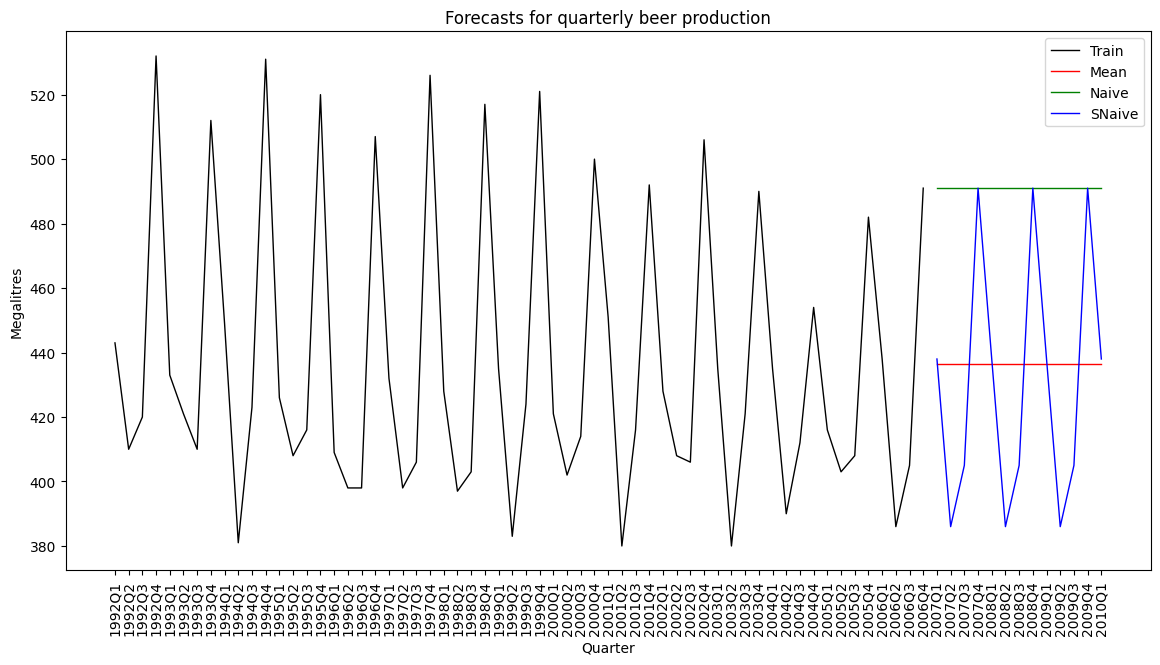

In [19]:
# plotting them all together

plt.figure(figsize=(14, 7))

# x-axis
x_axis = beer["Quarter"].values # get the periods
x_axis = [str(x) for x in x_axis] # convert to string to use as x-axis

# y-axis
y_axis = beer["Beer"].values # actual values

# plot the actual values
plt.plot(x_axis, y_axis, color="black", linestyle="-", linewidth=1)

# plot the predicted values
x_axis_pred = [str(x) for x in y_pred_Mean.index] # get periods 2007Q1 and so on to use as x-axis for predictions
plt.plot(x_axis_pred, y_pred_Mean.values, color="red", linestyle="-", linewidth=1)
plt.plot(x_axis_pred, y_pred_Naive, color="green", linestyle="-", linewidth=1)
plt.plot(x_axis_pred, y_pred_SNaive, color="blue", linestyle="-", linewidth=1)

# plot the legend
plt.legend(["Train", "Mean", "Naive", "SNaive"])

# plot the title
plt.title("Forecasts for quarterly beer production")

# plot the x-axis label
plt.xlabel("Quarter")
# 90 degree rotation of x-axis labels
plt.xticks(rotation=90)

# plot the y-axis label
plt.ylabel("Megalitres")

plt.show()

## **Example:** Google's daily closing stock price

In [20]:
gafa_stock = pd.read_csv('data/gafa_stock.csv')

In [21]:
gafa_stock["Date"] = pd.to_datetime(gafa_stock["Date"])
gafa_stock["DayOfYear"] = gafa_stock["Date"].dt.dayofyear

In [22]:
# Symbol == GOOG and year == 2015
flt = (gafa_stock["Symbol"] == "GOOG") & (gafa_stock["Date"].dt.year == 2015)
google_stock = gafa_stock[["DayOfYear", "Date", "Close"]][flt]

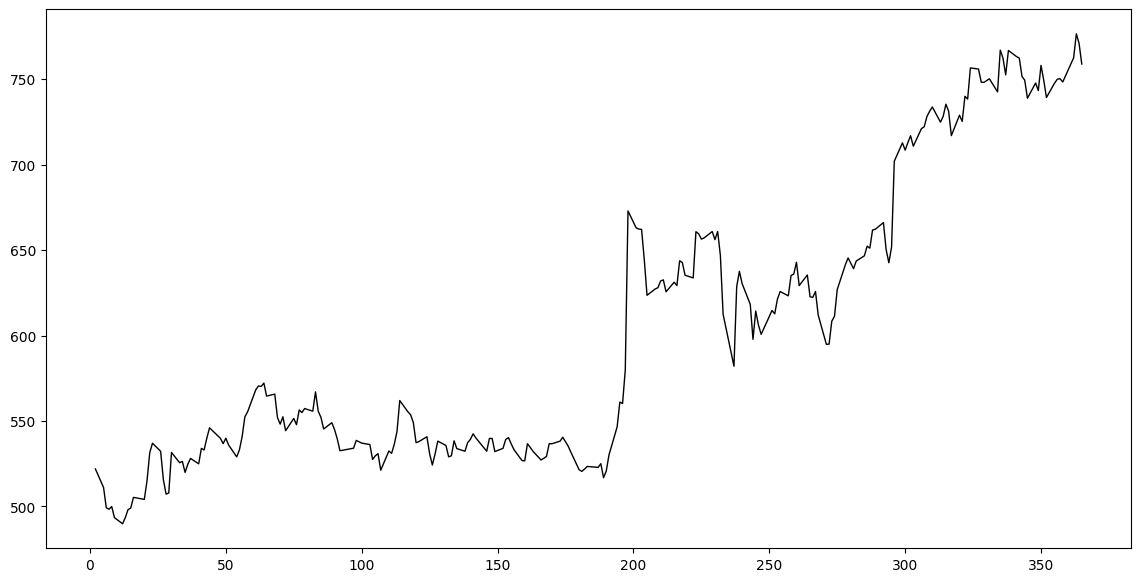

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(google_stock["DayOfYear"], google_stock["Close"], color="black", linestyle="-", linewidth=1)
plt.show()

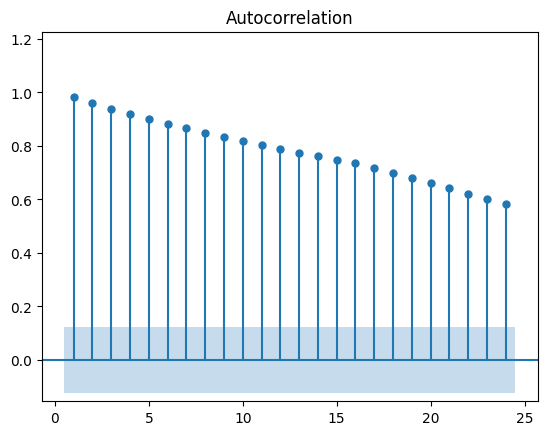

In [24]:
plot_acf(google_stock["Close"], lags=range(1, 25), fft=True, alpha=0.05, bartlett_confint=False, auto_ylims=True)
plt.show()

In [25]:
# fitting mean, naive and seasonal naive models

Mean = NaiveForecaster(strategy="mean")
Mean.fit(google_stock["Close"])
y_pred_Mean = Mean.predict(list(range(1, 32)))
y_pred_Mean.index = pd.period_range(start="2016-01-01", periods=31, freq="D")

Naive = NaiveForecaster(strategy="last")
Naive.fit(google_stock["Close"])
y_pred_Naive = Naive.predict(list(range(1, 32)))
y_pred_Naive.index = pd.period_range(start="2016-01-01", periods=31, freq="D")

Drift = NaiveForecaster(strategy="drift")
Drift.fit(google_stock["Close"])
y_pred_Drift = Drift.predict(list(range(1, 32)))
y_pred_Drift.index = pd.period_range(start="2016-01-01", periods=31, freq="D")

In [26]:
# Symbol == GOOG and jan-2016
flt = (gafa_stock["Symbol"] == "GOOG") & (gafa_stock["Date"] >= "2016-01-01") & (gafa_stock["Date"] <= "2016-01-31")
google_jan_2016 = gafa_stock[flt][["DayOfYear", "Date", "Close"]]

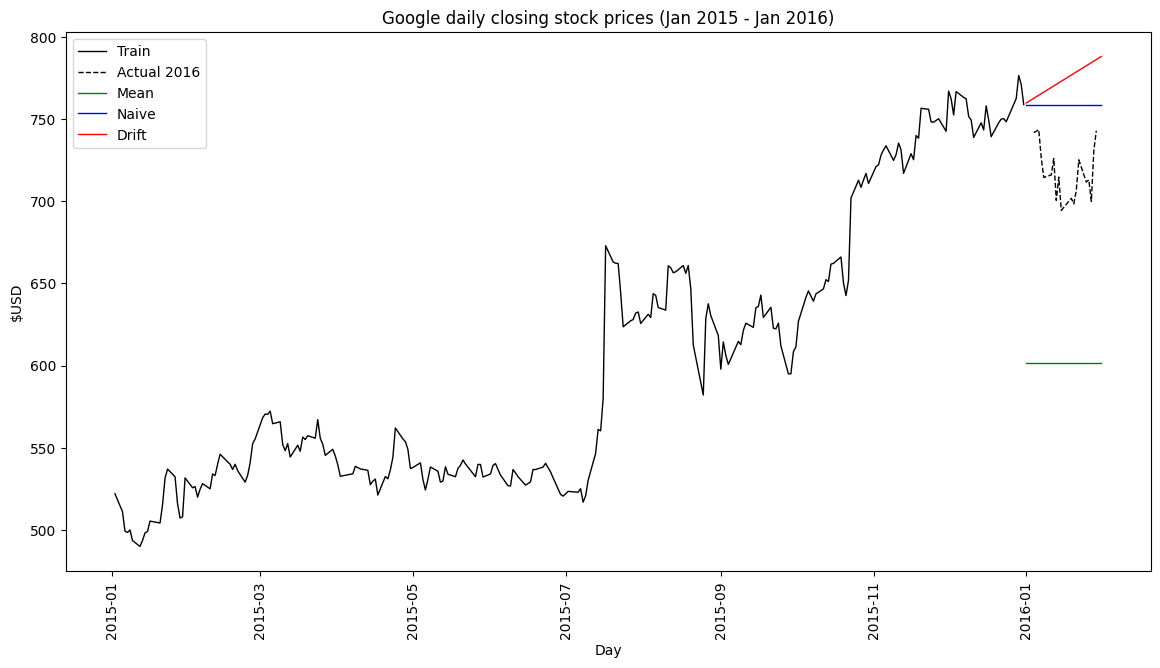

In [27]:
# plotting them all together

plt.figure(figsize=(14, 7))

# x-axis
x_axis = google_stock["Date"].values # get the periods
#x_axis = [str(x) for x in x_axis] # convert to string to use as x-axis

# y-axis
y_axis = google_stock["Close"].values # actual values

# plot the actual values
plt.plot(x_axis, y_axis, color="black", linestyle="-", linewidth=1)
plt.plot(google_jan_2016["Date"], google_jan_2016["Close"], color="black", linestyle="--", linewidth=1)

# plot the predicted values
x_axis_pred = y_pred_Mean.index # get periods 2007Q1 and so on to use as x-axis for predictions
plt.plot(x_axis_pred, y_pred_Mean.values, color="green", linestyle="-", linewidth=1)
plt.plot(x_axis_pred, y_pred_Naive.values, color="blue", linestyle="-", linewidth=1)
plt.plot(x_axis_pred, y_pred_Drift.values, color="red", linestyle="-", linewidth=1)

# plot the legend
plt.legend(["Train", "Actual 2016", "Mean", "Naive", "Drift"])

# plot the title
plt.title("Google daily closing stock prices (Jan 2015 - Jan 2016)")

# plot the x-axis label
plt.xlabel("Day")
# 90 degree rotation of x-axis labels
plt.xticks(rotation=90)

# plot the y-axis label
plt.ylabel("$USD")

plt.show()